<a href="https://colab.research.google.com/github/frank-morales2020/Cloud_curious/blob/master/waypoint_FTDEMO_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colab-env -q
!pip install datasets -q
!pip install transformers -q
!pip install evaluate -q
!pip install bitsandbytes -q
!pip install accelerate -q

In [3]:
from datasets import load_from_disk
import colab_env

#Prepare the Dataset
dataset = load_from_disk("/content/gdrive/MyDrive/datasets/flight_dataset_waypoints")
print(dataset)  # Inspect the dataset

Mounted at /content/gdrive
Dataset({
    features: ['input', 'label', 'distance', 'distance_category', 'waypoints', 'waypoint_names'],
    num_rows: 100
})


In [4]:
dataset

Dataset({
    features: ['input', 'label', 'distance', 'distance_category', 'waypoints', 'waypoint_names'],
    num_rows: 100
})

In [5]:
dataset[50]

{'input': 'Calculate the waypoints from IAH to SLC. Departure: 2024-11-19, Aircraft: Boeing 737, Weather: Foggy',
 'label': 3,
 'distance': 1924.167586997591,
 'distance_category': 'medium',
 'waypoints': [[29.9841416, -95.33298595614491],
  [37.513686035827114, -106.93251799350803],
  [36.41464071093567, -105.23939943032738],
  [34.762150224046536, -102.69367883494813],
  [40.790066100000004, -111.97989846185591]],
 'waypoint_names': ['IAH',
  'Beaver Creek Trail',
  'Colfax County',
  'County Road 2',
  'SLC']}

In [6]:
dataset[0]

{'input': 'Calculate the waypoints from CUN to BKK. Departure: 2024-11-04, Aircraft: Airbus A380, Weather: Windy',
 'label': 6,
 'distance': 17836.525435346728,
 'distance_category': 'longhaul',
 'waypoints': [[5.1096596, -74.0995854],
  [12.782602322717747, 80.9008208725117],
  [9.927809772864416, 23.2314206121804],
  [11.414439668812392, 53.26269364209044],
  [8.637413641278366, -2.8357522934803825],
  [11.52008701015119, 55.39686581317167],
  [7.7714598136892485, -20.328805472692444],
  [13.7524938, 100.4935089]],
 'waypoint_names': ['CUN',
  'Waypoint',
  'Vakaga',
  'Waypoint',
  'Bandoli',
  'Waypoint',
  'Waypoint',
  'BKK']}

In [7]:
dataset[99]

{'input': 'Calculate the waypoints from ZRH to PHX. Departure: 2024-08-06, Aircraft: Boeing 777, Weather: Cloudy',
 'label': 5,
 'distance': 9268.412143284295,
 'distance_category': 'long',
 'waypoints': [[47.463388050000006, 8.553366081422642],
  [41.840623093206034, -39.76134297318687],
  [38.64705199331531, -67.2027280785688],
  [37.042190923504364, -80.99281111721612],
  [40.82159940375261, -48.51750359060834],
  [36.47494935955649, -85.8669453441339],
  [33.43284865, -112.00679145657891]],
 'waypoint_names': ['ZRH',
  'Waypoint',
  'Waypoint',
  'Wythe County',
  'Waypoint',
  'Oak Grove Road',
  'PHX']}

In [13]:
!pip install colab-env -q
!pip install datasets -q
!pip install transformers -q
!pip install evaluate -q
!pip install bitsandbytes -q
!pip install accelerate -q

from datasets import load_from_disk
from datasets import Dataset
import torch
import colab_env


dataset = Dataset.load_from_disk("/content/gdrive/MyDrive/datasets/flight_dataset_waypoints")

from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, BitsAndBytesConfig
import torch
import bitsandbytes as bnb
import evaluate
from peft import LoraConfig, get_peft_model
import warnings
warnings.filterwarnings("ignore")

# Model and Tokenizer
#model_name = "meta-llama/Llama-2-7b-chat-hf"
model_name = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Quantization Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# PEFT Configuration (LoRA)
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Tokenize and Format
def tokenize_function(examples):
    # Directly use waypoint numbers as labels
    examples["labels"] = examples["label"]
    tokenized_output = tokenizer(
        examples["input"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    # Instead of assigning labels directly, shift them for causal LM
    tokenized_output['labels'] = tokenized_output['input_ids'].copy()
    # Replace input_ids corresponding to pad_token with -100 in labels
    tokenized_output['labels'] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label_list]
        for label_list in tokenized_output['labels']
    ]
    return tokenized_output

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print('\n')
print(tokenized_datasets)
print('\n')

# Remove unnecessary columns
tokenized_datasets = tokenized_datasets.remove_columns(["input", "label"])
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Split Dataset
train_testvalid = tokenized_datasets.train_test_split(test_size=0.2, seed=42)
train_dataset = train_testvalid["train"]
testvalid_dataset = train_testvalid["test"]
test_valid = testvalid_dataset.train_test_split(test_size=0.5, seed=42)
eval_dataset = test_valid["test"]
test_dataset = test_valid["train"]

small_train_dataset = train_dataset.shuffle(seed=42).select(range(70))
small_eval_dataset = eval_dataset.shuffle(seed=42).select(range(5))

# Metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits[:, :-1, :].argmax(-1)
    labels_cleaned = labels[:, 1:]
    labels_cleaned = labels_cleaned[labels_cleaned != -100]
    predictions_cleaned = predictions.flatten()[labels[:, 1:].flatten() != -100]
    return metric.compute(predictions=predictions_cleaned, references=labels_cleaned)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
    report_to='none',
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


Map:   0%|          | 0/100 [00:00<?, ? examples/s]



Dataset({
    features: ['input', 'label', 'distance', 'distance_category', 'waypoints', 'waypoint_names', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 100
})




No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
10,2.400500,2.090137,0.530973
20,1.942100,1.715286,0.637168
30,1.627100,1.504621,0.672566
40,1.472100,1.405443,0.672566


TrainOutput(global_step=45, training_loss=1.8118406825595432, metrics={'train_runtime': 159.7154, 'train_samples_per_second': 2.191, 'train_steps_per_second': 0.282, 'total_flos': 1912261469798400.0, 'train_loss': 1.8118406825595432, 'epoch': 5.0})

In [ ]:

steps =
training_loss =
validation_loss =
accuracy =

In [14]:
# Data from the table
steps = [10, 20, 30, 40]
training_loss = [2.400500, 1.942100, 1.627100, 1.472100]
validation_loss = [2.090137, 1.715286, 1.504621, 1.405443]
accuracy = [0.530973, 0.637168, 0.672566, 0.672566]

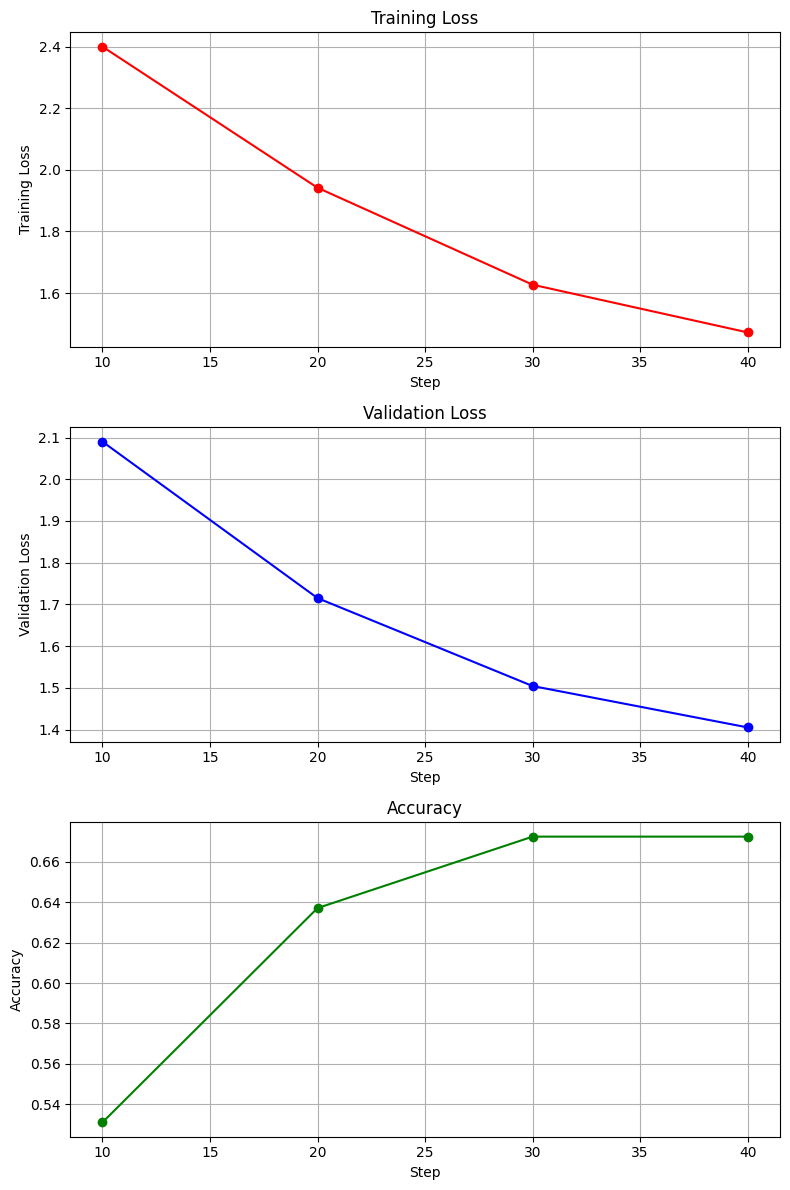

In [15]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot Training Loss
axs[0].plot(steps, training_loss, marker='o', color='red')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Training Loss')
axs[0].grid(True)

# Plot Validation Loss
axs[1].plot(steps, validation_loss, marker='o', color='blue')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Validation Loss')
axs[1].grid(True)

# Plot Accuracy
axs[2].plot(steps, accuracy, marker='o', color='green')
axs[2].set_title('Accuracy')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Accuracy')
axs[2].grid(True)

plt.tight_layout()
plt.show()